In [113]:
import pandas as pd

# File paths for the uploaded files
train_scores_path = 'train_scores.csv'
train_logs_path = 'train_logs.csv'
sample_submission_path = 'sample_submission.csv'
test_logs_path = 'test_logs.csv'

# Loading the data into Pandas DataFrames
train_scores = pd.read_csv(train_scores_path)   
train_logs = pd.read_csv(train_logs_path)
sample_submission = pd.read_csv(sample_submission_path)
test_logs = pd.read_csv(test_logs_path)

# Display the first few rows of each DataFrame to understand their structure
train_scores.head(), train_logs.head(), sample_submission.head(), test_logs.head()
len(train_scores), len(train_logs), len(sample_submission), len(test_logs)

(2471, 8405898, 3, 6)

In [114]:
import pandas as pd

# Load the data
train_logs_path = 'train_logs.csv'  # Replace with the actual path
train_logs = pd.read_csv(train_logs_path)

# Display the first few rows to understand its structure
print(train_logs.head())


         id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1  


In [115]:
# Grouping by user ID and aggregating data
aggregated_data = train_logs.groupby('id').agg({
    'down_time': 'sum',
    'up_time': 'sum',
    'action_time': 'mean',  # Average action time
    'event_id': 'count',    # Count of events
    'cursor_position': 'max',  # Maximum cursor position
    'word_count': 'max'    # Maximum word count
}).reset_index()

# Adding a new feature: total duration (up_time - down_time)
aggregated_data['total_duration'] = aggregated_data['up_time'] - aggregated_data['down_time']

# Display the first few rows of the aggregated data
print(aggregated_data.head())


         id   down_time     up_time  action_time  event_id  cursor_position  \
0  001519c8  2168798234  2169095477   116.246774      2557             1539   
1  0022f953  1273271023  1273546414   112.221271      2454             1676   
2  0042269b  3426641982  3427063183   101.837766      4136             2291   
3  0059420b  1222211589  1222401185   121.848329      1556             1047   
4  0075873a  1805499474  1805813176   123.943896      2531             1402   

   word_count  total_duration  
0         256          297243  
1         323          275391  
2         404          421201  
3         206          189596  
4         252          313702  


In [116]:
# Ensure that 'id' is the index for aggregated data
aggregated_data.set_index('id', inplace=True)

# Recalculate the additional features with 'id' as the index
activity_counts = pd.get_dummies(train_logs['activity']).groupby(train_logs['id']).sum()
space_down_event = (train_logs['down_event'] == 'Space').astype(int).groupby(train_logs['id']).sum()
space_up_event = (train_logs['up_event'] == 'Space').astype(int).groupby(train_logs['id']).sum()
text_changes = (train_logs['text_change'] != 'NoChange').astype(int).groupby(train_logs['id']).sum()

# Merging these features with the aggregated data
extended_features = pd.concat([aggregated_data, activity_counts, space_down_event, space_up_event, text_changes], axis=1)

# Renaming the new columns for clarity
extended_features.rename(columns={0: 'space_down_events', 1: 'space_up_events', 2: 'text_changes'}, inplace=True)

# Resetting index for convenience
extended_features.reset_index(inplace=True)

# Display the first few rows of the extended dataset
print(extended_features.head())

extended_features.to_csv("processed_data.csv")


         id   down_time     up_time  action_time  event_id  cursor_position  \
0  001519c8  2168798234  2169095477   116.246774      2557             1539   
1  0022f953  1273271023  1273546414   112.221271      2454             1676   
2  0042269b  3426641982  3427063183   101.837766      4136             2291   
3  0059420b  1222211589  1222401185   121.848329      1556             1047   
4  0075873a  1805499474  1805813176   123.943896      2531             1402   

   word_count  total_duration  Input  Move From [0, 158] To [234, 392]  ...  \
0         256          297243   2010                                 0  ...   
1         323          275391   1938                                 0  ...   
2         404          421201   3515                                 0  ...   
3         206          189596   1304                                 0  ...   
4         252          313702   1942                                 0  ...   

   Move From [923, 1077] To [340, 494]  Move From 

In [117]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(extended_features, test_size=0.20, random_state=42)

# Output the size of the training and testing datasets
print("Training Set Size:", train_set.shape)
print("Testing Set Size:", test_set.shape)


Training Set Size: (1976, 61)
Testing Set Size: (495, 61)


In [118]:
# Summary Statistics
print(train_set.describe())


          down_time       up_time  action_time      event_id  cursor_position  \
count  1.976000e+03  1.976000e+03  1976.000000   1976.000000      1976.000000   
mean   2.723741e+09  2.724075e+09    99.960906   3410.969130      2236.889170   
std    1.782005e+09  1.782117e+09    24.580941   1604.027846       970.986165   
min    1.723896e+07  1.725651e+07    14.131749    262.000000       207.000000   
25%    1.567100e+09  1.567313e+09    83.416385   2192.750000      1491.000000   
50%    2.334999e+09  2.335309e+09    96.805660   3101.000000      2006.000000   
75%    3.440922e+09  3.441403e+09   114.573862   4282.000000      2764.000000   
max    2.424430e+10  2.424494e+10   282.612447  12876.000000      7802.000000   

        word_count  total_duration        Input  \
count  1976.000000    1.976000e+03  1976.000000   
mean    390.882085    3.337112e+05  2723.941802   
std     172.109688    1.571591e+05  1201.373838   
min      35.000000    1.754100e+04   230.000000   
25%     255.750

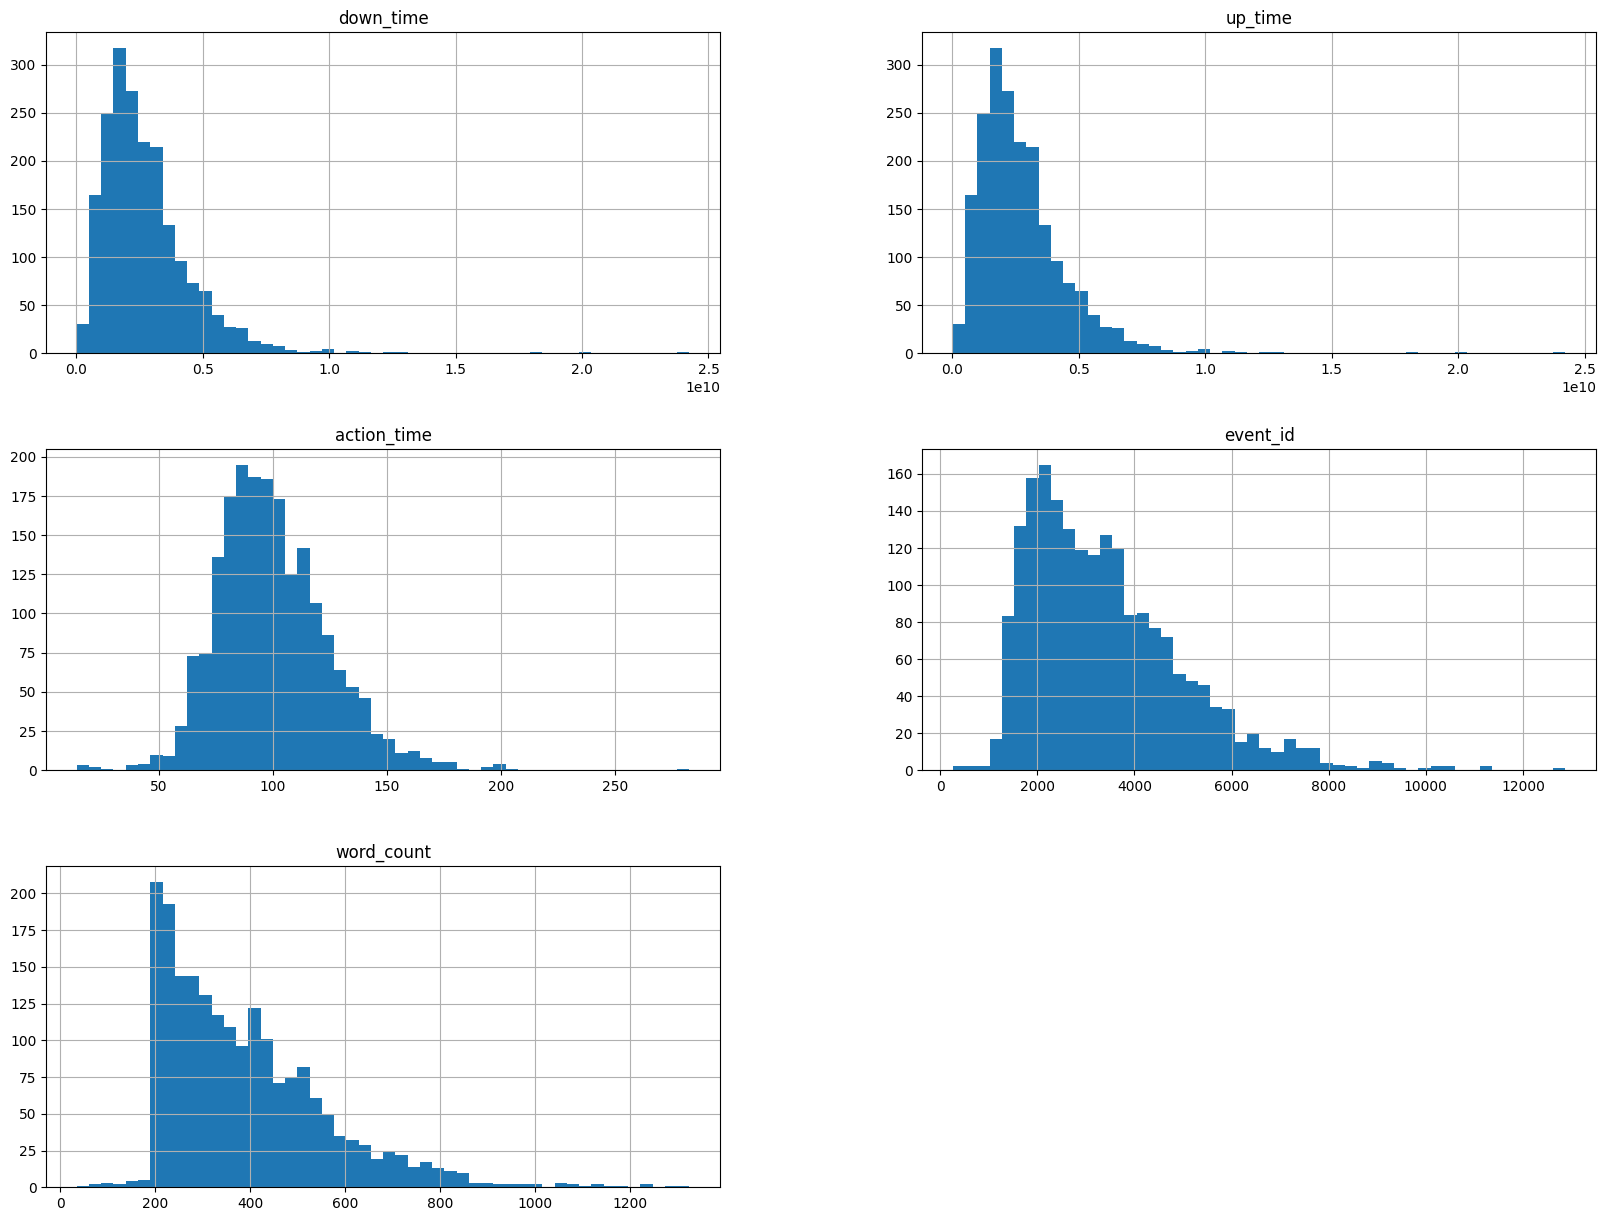

In [119]:
import matplotlib.pyplot as plt

# Histograms for a selection of features
train_set[['down_time', 'up_time', 'action_time', 'event_id', 'word_count']].hist(bins=50, figsize=(20,15))
plt.show()


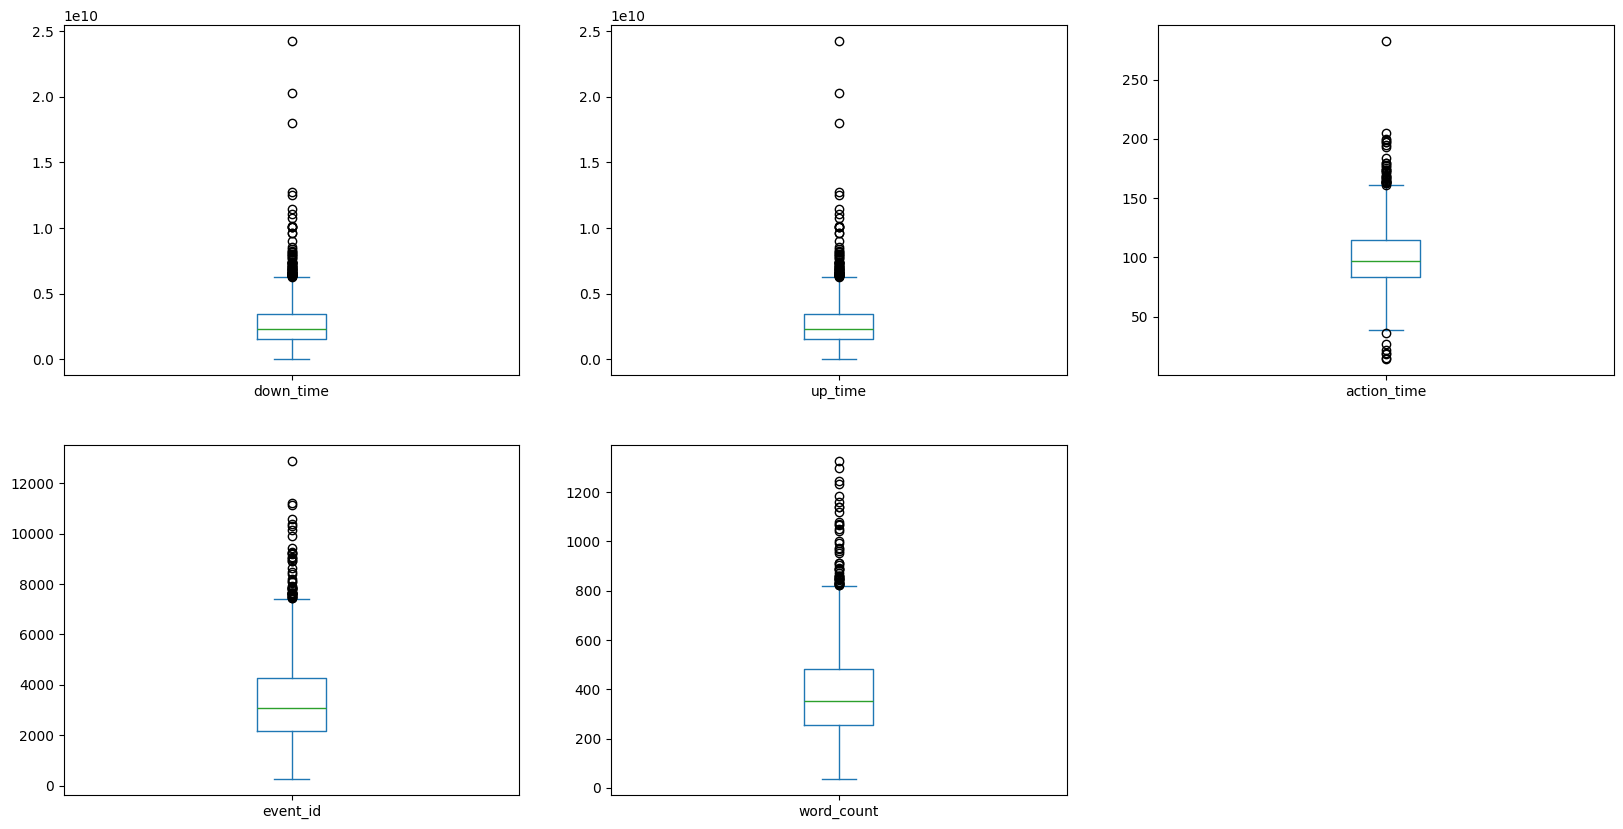

In [120]:
# Box plots for the same selection of features
train_set[['down_time', 'up_time', 'action_time', 'event_id', 'word_count']].plot(kind='box', subplots=True, layout=(2,3), figsize=(20,10))
plt.show()


In [121]:
# Outlier detection for each feature
for feature in features:
    # Calculating Z-scores for the feature
    z_scores = np.abs(stats.zscore(train_set[feature]))

    # Identifying outliers
    outliers = np.where(z_scores > threshold)[0]  # Indices of outliers

    # Printing the first 10 outlier instances for this feature
    print(f"Outliers in feature '{feature}':")
    for i in range(min(len(outliers), 10)):  # Print up to 10 outliers
        data_index = outliers[i]
        outlier_value = train_set.iloc[data_index][feature]
        print(f" - Index {data_index}: {outlier_value}")

    print()  # Newline for readability


NameError: name 'features' is not defined

In [ ]:
extended_features

,id,down_time,up_time,action_time,event_id,cursor_position,word_count,total_duration,Input,"Move From [0, 158] To [234, 392]",...,"Move From [923, 1077] To [340, 494]","Move From [944, 1102] To [1050, 1208]","Move From [999, 1000] To [1000, 1001]",Nonproduction,Paste,Remove/Cut,Replace,down_event,up_event,text_change
0,001519c8,2168798234,2169095477,116.246774,2557,1539,256,297243,2010,0,...,0,0,0,120,0,417,7,357,357,2437
1,0022f953,1273271023,1273546414,112.221271,2454,1676,323,275391,1938,0,...,0,0,0,254,1,260,1,391,391,2200
2,0042269b,3426641982,3427063183,101.837766,4136,2291,404,421201,3515,0,...,0,0,0,175,0,439,7,552,552,3961
3,0059420b,1222211589,1222401185,121.848329,1556,1047,206,189596,1304,0,...,0,0,0,99,1,151,1,243,243,1457
4,0075873a,1805499474,1805813176,123.943896,2531,1402,252,313702,1942,0,...,0,0,0,72,0,517,0,324,324,2459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3488386746,3488886416,105.437856,4739,1634,461,499670,3588,0,...,0,0,0,189,0,960,2,651,651,4550
2467,ffbef7e5,2192480040,2192694261,82.266129,2604,1877,438,214221,2395,0,...,0,0,0,148,0,60,1,447,447,2456
2468,ffccd6fd,3764472937,3764704517,75.605615,3063,2761,201,231580,2849,0,...,0,0,0,126,0,88,0,1861,1861,2937
2469,ffec5b38,1869073112,1869362551,89.277915,3242,2133,413,289439,2895,0,...,0,0,0,71,0,276,0,457,457,3171


In [ ]:
from sklearn.model_selection import train_test_split

# Randomly splitting the extended_features dataset
train_data, test_data = train_test_split(extended_features, test_size=0.20, random_state=42)

# Confirming the size of the training and testing datasets
print("Training Data Size:", train_data.shape[0])
print("Testing Data Size:", test_data.shape[0])


Training Data Size: 1976
Testing Data Size: 495


In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaled_features = scaler.fit_transform(extended_features.drop(['id'], axis=1))  # Exclude non-numeric or identifier columns


/usr/local/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: 

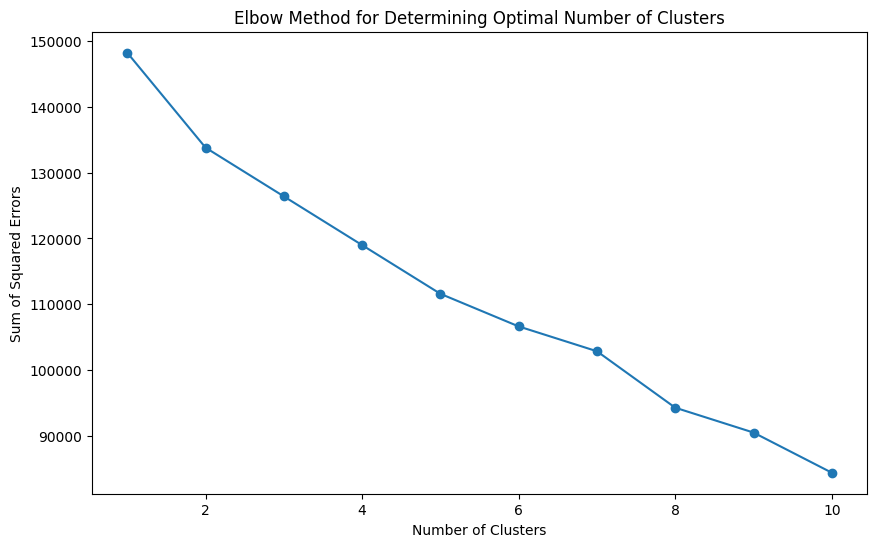

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


sse = []
for k in range(1, 11):  # Trying different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors')
plt.show()


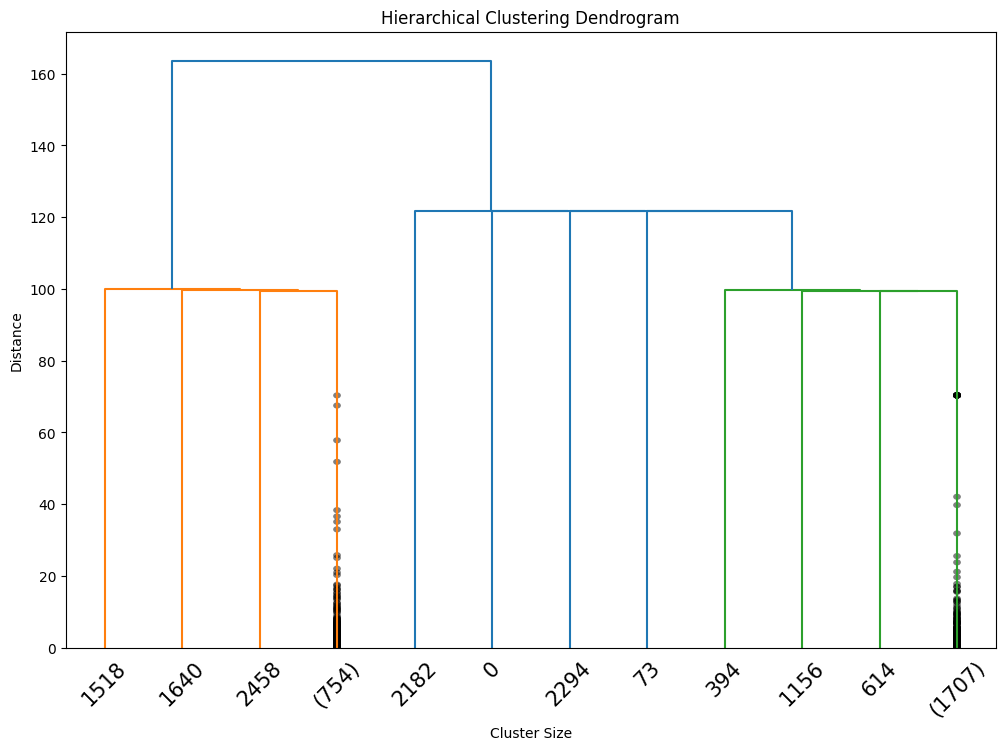

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(scaled_features, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


In [ ]:

unsupervised_data = scaled_features



In [ ]:
# Assuming kmeans_clusters and hierarchical_clusters are the results from your clustering
extended_features['kmeans_cluster'] = kmeans_clusters  # From K-Means clustering

# For Hierarchical Clustering, you will need to perform the fit_predict step as shown earlier
from sklearn.cluster import AgglomerativeClustering
hierarchical_model = AgglomerativeClustering(n_clusters=3)
extended_features['hierarchical_cluster'] = hierarchical_model.fit_predict(unsupervised_data)


In [ ]:
# Assuming that 'extended_features' is the DataFrame with all the features, including cluster labels
# Make sure to exclude non-numeric columns like 'id' or other categorical features
numeric_features = extended_features.select_dtypes(include=[np.number])

# Profile for K-Means clusters
kmeans_profiles = numeric_features.groupby('kmeans_cluster').mean()

# Profile for Hierarchical clusters
hierarchical_profiles = numeric_features.groupby('hierarchical_cluster').mean()

# Now you can print the profiles
print("K-Means Cluster Profiles:\n", kmeans_profiles)
print("\nHierarchical Cluster Profiles:\n", hierarchical_profiles)


K-Means Cluster Profiles:
                    down_time       up_time  action_time     event_id  \
kmeans_cluster                                                         
0               1.862954e+09  1.863209e+09   101.363887  2537.792959   
1               4.467024e+09  4.467522e+09    96.903395  5227.066751   
2               1.459911e+09  1.460256e+09   152.169462  2266.000000   

                cursor_position  word_count  total_duration       Input  \
kmeans_cluster                                                            
0                   1748.552506  305.875895   255428.844869  2071.48926   
1                   3253.977330  567.610831   498802.011335  4097.13728   
2                   1505.000000  276.000000   344816.000000  1853.00000   

                Move From [0, 158] To [234, 392]  \
kmeans_cluster                                     
0                                       0.000597   
1                                       0.000000   
2                           

In [ ]:

extended_features = extended_features.join(train_scores.set_index('id'), on='id')


kmeans_outcome_analysis = extended_features.groupby('kmeans_cluster')['score'].mean()
hierarchical_outcome_analysis = extended_features.groupby('hierarchical_cluster')['score'].mean()


KeyError: 'kmeans_cluster'

In [ ]:
hierarchical_outcome_analysis

hierarchical_cluster
0    3.395213
1    4.427345
2    3.000000
Name: score, dtype: float64

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')


from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(scaled_features)


from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f'Davies-Bouldin Index: {db_index}')




Silhouette Score: 0.36239037310248357
Davies-Bouldin Index: 0.8746323447577876


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95) # Preserve 95% of variance
train_logs_pca = pca.fit_transform(scaled_features)


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(scaled_features, kmeans.labels_)
feature_importances = rf.feature_importances_

In [ ]:
dbscan_clusters
train_logs_pca

array([[-2.22472521e+00,  3.79450289e+01, -4.76090513e+01, ...,
         8.37199686e-02,  4.47833577e-02,  3.30883825e-01],
       [-1.85658686e+00, -3.78590690e-02,  1.33894680e-03, ...,
         2.36101311e-01, -3.59200312e-01, -1.43879870e-01],
       [ 1.28569198e+00,  2.64467674e-02, -1.39159404e-02, ...,
        -1.15508422e-01, -5.23312571e-02, -3.95354932e-01],
       ...,
       [ 3.08705503e+00, -8.19042546e-02,  9.85899569e-03, ...,
         5.02353051e-01,  2.93693657e-01,  1.56248712e+00],
       [-5.53670113e-01, -6.77230070e-02, -4.74577578e-03, ...,
         7.93993526e-02,  1.61156170e-01,  3.90138706e-01],
       [-1.49911258e-01,  4.70116613e-02, -1.29314200e-01, ...,
         1.41318725e+01,  1.95962948e+01,  4.70732395e+00]])

In [ ]:
feature_importances

array([7.55646646e-02, 5.77014898e-02, 6.88676665e-03, 1.39217079e-01,
       5.16414269e-02, 4.57428421e-02, 7.81077217e-02, 1.30029174e-01,
       9.75279190e-05, 6.33810795e-10, 5.34775824e-04, 1.93494310e-05,
       8.89715444e-10, 1.76523689e-09, 0.00000000e+00, 3.97416716e-07,
       8.26413297e-11, 9.90301701e-06, 5.89047149e-09, 1.62331689e-08,
       2.43573434e-09, 2.39034283e-07, 6.90064023e-08, 4.97781249e-05,
       3.63905315e-05, 1.86899337e-09, 7.98303965e-08, 1.76663393e-05,
       1.72486755e-10, 2.98165060e-07, 1.17754278e-05, 7.81600778e-07,
       1.68662400e-06, 0.00000000e+00, 7.00760085e-05, 2.17343803e-05,
       1.06695966e-08, 3.63011368e-05, 7.53098717e-08, 2.72042786e-05,
       4.14229150e-07, 4.28062539e-09, 3.21288326e-04, 1.04601107e-07,
       3.60220971e-07, 8.17216963e-08, 1.35967097e-04, 6.92966760e-04,
       6.15631935e-05, 9.88528245e-08, 5.24327434e-05, 7.52939055e-08,
       2.71799345e-06, 1.74828047e-02, 1.09896858e-03, 1.98087992e-02,
      

In [ ]:
import sklearn

In [ ]:
from sklearn.model_selection import train_test_split

X = extended_features.drop('id', axis = 1)  # Features
y = train_scores.drop('id', axis = 1)              # Target

# train_set, test_set = train_test_split(extended_features, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
extended_features.head()
len(extended_features.columns)

61

In [ ]:
# Merging the data and labels on the 'id' column
merged_df = pd.merge(extended_features, train_scores, on='id')

# Dropping the 'Unnamed: 0' column as it seems to be an unnecessary index column

X = merged_df.drop(columns=['id', 'score'])  # Dropping 'id' as it's not a feature
y = merged_df['score']

# Splitting data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((1976, 60), (495, 60), (1976,), (495,))

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge

#Ridge Regression

parameters = {'alpha': [0.01, 0.1, 1, 10, 100, 1000, 10000]}
ridge = Ridge()
clf = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error')
clf.fit(X_train_scaled, y_train)

# Best alpha
best_alpha = clf.best_params_['alpha']

# Train Ridge model with the best alpha
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = ridge_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'Best Alpha: {best_alpha}')
print(f'Mean Squared Error: {mse}')
rmse = np.sqrt(mse)
print(rmse)
print(f'R-squared: {r2}')

Best Alpha: 10
Mean Squared Error: 0.4812173139335391
0.6936982873941229
R-squared: 0.5063138492375938


Model Summary:
       Metric      Value
0  Best Alpha  10.000000
1         MSE   0.481217
2        RMSE   0.693698
3   R-squared   0.506314


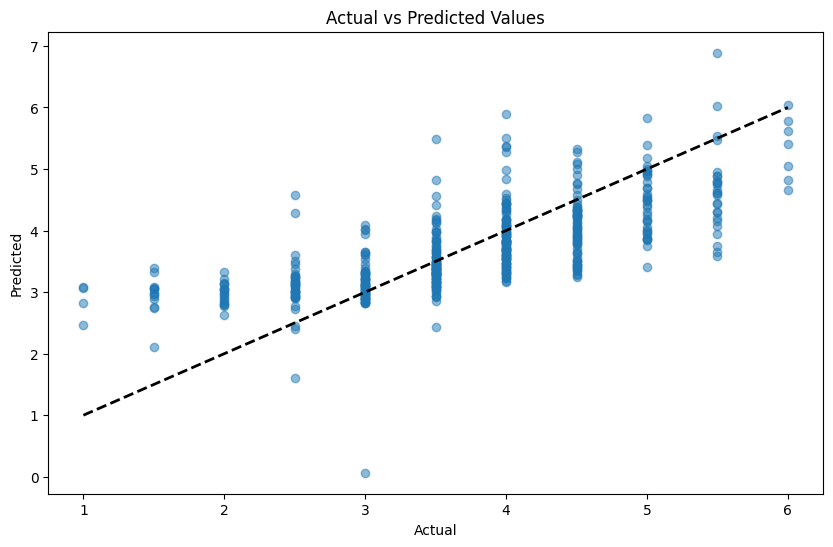

In [ ]:
model_summary = pd.DataFrame({
    'Metric': ['Best Alpha', 'MSE', 'RMSE', 'R-squared'],
    'Value': [best_alpha, mse,rmse, r2]
})

# Print the model summary table
print("Model Summary:")
print(model_summary)

# Plotting Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Reference line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#SVR Regression

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Create SVR model
svr = SVR()

# Grid search with cross-validation
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_

# Train SVR model with the best parameters
svr_optimal = SVR(**best_params)
svr_optimal.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_svr = svr_optimal.predict(X_test_scaled)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

# Print the results
print(f'Best Parameters: {best_params}')
print(f'MSE: {mse_svr}')

print(f'R-squared: {r2_svr}')

Best Parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
MSE: 0.4550136112051863
R-squared: 0.5610641335214536


In [ ]:
svr_model_summary = pd.DataFrame({
    'Metric': ['C', 'Epsilon', 'Kernel', 'MSE', 'RMSE', 'R-squared'],
    'Value': [
        best_params['C'],
        best_params['epsilon'],
        best_params['kernel'],
        mse_svr,
        np.sqrt(mse_svr),
        r2_svr
    ]
})

# Display the model summary table
print(svr_model_summary)

      Metric     Value
0          C        10
1    Epsilon       0.1
2     Kernel       rbf
3        MSE  0.455014
4       RMSE  0.674547
5  R-squared  0.561064


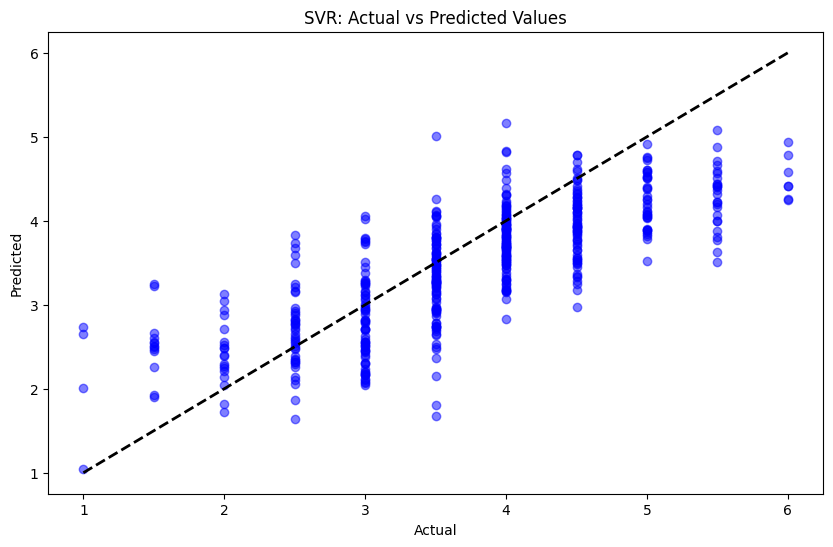

In [ ]:
# Plotting Actual vs Predicted Values for SVR
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Ideal reference line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('SVR: Actual vs Predicted Values')
plt.show()


In [ ]:
print(f'RMSE: {np.sqrt(mse_svr)}')

RMSE: 0.6745469673826918


In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Random Forests Classification


# Convert the scores to integer class labels
y_class = y.astype(int)

# Splitting data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create Random Forest model
rf_classifier = RandomForestClassifier()

# Grid search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X_train_class, y_train_class)

# Best parameters
best_params = grid_search.best_params_

# Train Random Forest model with the best parameters
rf_optimal = RandomForestClassifier(**best_params)
rf_optimal.fit(X_train_class, y_train_class)

# Predict and evaluate
y_pred_class = rf_optimal.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f'Accuracy: {accuracy}')

# Classification Report and Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_class))

Accuracy: 0.5353535353535354

Classification Report:
              precision    recall  f1-score   support

           1       0.25      0.06      0.10        17
           2       0.37      0.23      0.29        60
           3       0.54      0.60      0.57       171
           4       0.57      0.75      0.65       177
           5       0.45      0.22      0.30        63
           6       0.00      0.00      0.00         7

    accuracy                           0.54       495
   macro avg       0.36      0.31      0.32       495
weighted avg       0.50      0.54      0.51       495


Confusion Matrix:
[[  1   4  12   0   0   0]
 [  1  14  42   3   0   0]
 [  2  20 103  45   1   0]
 [  0   0  32 133  12   0]
 [  0   0   1  48  14   0]
 [  0   0   0   3   4   0]]


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
importances = rf_optimal.feature_importances_

# Get the feature names from the training set
feature_names = X_train.columns.tolist()

# Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                                   feature  importance
4                          cursor_position    0.127241
7                                    Input    0.102195
5                               word_count    0.097363
59                             text_change    0.083165
3                                 event_id    0.077329
57                              down_event    0.074066
58                                up_event    0.066552
6                           total_duration    0.062808
1                                  up_time    0.057685
0                                down_time    0.056613
55                              Remove/Cut    0.056322
53                           Nonproduction    0.049168
2                              action_time    0.047052
56                                 Replace    0.025905
54                                   Paste    0.010241
9           Move From [0, 1] To [590, 591]    0.000670
29      Move From [218, 220] To [206, 208]    0.000436
37      Mo

Best Parameters: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}
MSE: 0.3849126024236734
R-squared: 0.6051139151308089


NameError: name 'new_test_data' is not defined